In [94]:
!pip install chronos-forecasting
!pip install seaborn
import pandas as pd  # requires: pip install pandas
import numpy as np
import torch
from chronos import BaseChronosPipeline
from chronos import ChronosBoltPipeline
import matplotlib.pyplot as plt
from chronos.chronos import ChronosPipeline
import seaborn as sns

In [3]:
#WQL FUNCTION (Sourced from chatGPT)


def quantile_loss(y_true, y_pred, alpha):
    """
    Computes quantile loss for a given quantile level alpha.
    
    Parameters:
    - y_true: True values (numpy array of shape (N,))
    - y_pred: Predicted quantile values (numpy array of shape (N,))
    - alpha: Quantile level (scalar)

    Returns:
    - Quantile loss (scalar)
    """
    diff = y_true - y_pred
    return np.maximum(alpha * diff, (alpha - 1) * diff).mean()

def weighted_quantile_loss(y_true, y_pred_quantiles, quantile_levels):
    """
    Computes the Weighted Quantile Loss (WQL) with the modified shape of predictions.

    Parameters:
    - y_true: True values (numpy array of shape (N,))
    - y_pred_quantiles: Predicted quantiles (numpy array of shape (K, N), where K is the number of quantiles)
    - quantile_levels: List or array of quantile levels (K,)

    Returns:
    - Weighted Quantile Loss (scalar)
    """
    assert y_pred_quantiles.shape[0] == len(quantile_levels), "Mismatch in quantile dimensions"

    # Compute WQL for each quantile
    wql_per_quantile = [
        (2 * quantile_loss(y_true, y_pred_quantiles[j, :], alpha)) / np.abs(y_true).sum()
        for j, alpha in enumerate(quantile_levels)
    ]
    
    # Final WQL (mean over quantiles)
    return np.mean(wql_per_quantile)

In [13]:
#MASE
def mase(y_true, y_pred, y_past, S):
    """
    Computes the Mean Absolute Scaled Error (MASE) while ignoring NaNs in the input arrays.

    Parameters:
    - y_true: Actual values (numpy array of shape (H,))
    - y_pred: Predicted values (numpy array of shape (H,))
    - y_past: Historical values (numpy array of shape (C,)) for computing seasonal naive MAE
    - S: Seasonality parameter (integer)

    Returns:
    - MASE score (scalar)
    """
    # Mask NaNs in y_true and corresponding elements in y_pred
    valid_mask = ~np.isnan(y_true)
    y_true_filtered = y_true[valid_mask]
    y_pred_filtered = y_pred[valid_mask]

    # Mask NaNs in y_past for seasonal naive MAE calculation
    past_valid_mask = ~np.isnan(y_past)
    y_past_filtered = y_past[past_valid_mask]

    # Ensure enough data remains after filtering
    if len(y_true_filtered) == 0 or len(y_past_filtered) <= S:
        return np.inf  # Avoid division by zero or invalid computation

    H = len(y_true_filtered)  # Adjusted prediction horizon
    C = len(y_past_filtered)  # Adjusted context length

    # Compute the numerator (MAE of forecast)
    numerator = np.sum(np.abs(y_pred_filtered - y_true_filtered)) / H

    # Compute the denominator (MAE of seasonal naive forecast)
    denominator = np.sum(np.abs(y_past_filtered[:-S] - y_past_filtered[S:])) / (C - S)

    return numerator / denominator if denominator != 0 else np.inf


# Create dataframe for each test

In [88]:
def metrics(y_true,y_pred,quantiles,y_past, s):
    wql = weighted_quantile_loss(y_true,y_pred,quantiles)
    mase_met = mase(y_true,y_pred[4],y_past,s)
    return wql, mase_met
#1. Ecological Datasets
#2. Samples of attractors that were use in training 
#3. Sample of attractors that were not in training 
#4. (For Experiment 4 and 5 only) Samples of ecological data that 
def forecast_pipeline(pipeline, model_name):
    quantiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    RIU = pd.read_csv('Data/RIU_cleaned.csv')
    forecast = pipeline.predict_quantiles(
        context=torch.tensor(RIU["Total abundance"].iloc[:-12]), prediction_length=12
    )
    forecast = forecast[0].permute(0, 2, 1) 
    # IMPORTANT METRIC BELOW (Ecological Data)
    RIU_wql, RIU_mase = metrics(RIU["Total abundance"].iloc[-12:].to_numpy(), forecast[0].numpy(), quantiles,RIU["Total abundance"].iloc[:-12].to_numpy(), 12)
    print('RIU done')
    LZ = pd.read_csv('Data/LZ_data.csv').iloc[1:-31].reset_index()
    LZ_wql_agg = []
    LZ_mase_agg = []
    test_LZ_wql_agg = []
    test_LZ_mase_agg = []
    test_LZs = ['Cyclops sp SU C1-C3',
    'Gymnodinium sp',
    'Erkenia subaequiciliata',
    'Aphanizomenon flos-aquae',
    'Asterionella formosa',
    'Elakatothrix gelatinosa',
    'Staurastrum sp',
    'Diaptomus sp C4-C5']
    for column in LZ.columns[2:]:
        forecast = pipeline.predict_quantiles(
        context=torch.tensor(LZ[column].iloc[:-12]), prediction_length=12)
        forecast = forecast[0].permute(0, 2, 1) 
        LZ_wql, LZ_mase = metrics(LZ[column].iloc[-12:].to_numpy(), forecast[0].numpy(), quantiles,LZ[column].iloc[:-12].to_numpy(), 12)
        if LZ_wql == np.inf:
            LZ_wql = 1
        LZ_wql_agg.append(LZ_wql)
        LZ_mase_agg.append(LZ_mase)
        if column in test_LZs:
            test_LZ_wql_agg.append(LZ_wql)
            test_LZ_mase_agg.append(LZ_mase)
    #IMPORTANT METRIC BELOW (Ecological data)
    mean_LZ_wql = np.mean(LZ_wql_agg)
    mean_LZ_mase = np.mean(LZ_mase_agg)
    test_mean_LZ_wql = np.mean(test_LZ_wql_agg)
    test_mean_LZ_mase = np.mean(test_LZ_mase_agg)
    print('LZ Done')
    
    #Synthetic attractors 
    synth_att = pd.read_csv('Data/Synthetic_attractor_test_data.csv')
    synt_wql_agg = []
    synt_mase_agg = []
    for column in synth_att.columns[1::20]:
        forecast = pipeline.predict_quantiles(
        context=torch.tensor(synth_att[column].iloc[:-12]), prediction_length=12)
        forecast = forecast[0].permute(0, 2, 1) 
        synt_wql, synt_mase = metrics(synth_att[column].iloc[-12:].to_numpy(), forecast[0].numpy(), quantiles,synth_att[column].iloc[:-12].to_numpy(), 12)
        if synt_wql == np.inf:
            LZ_wql = 1
        synt_mase_agg.append(synt_mase)
        synt_wql_agg.append(synt_wql)
        #print(column)
    #IMPORTNANT METRIC BELOW (synthetic data)
    mean_synt_wql = np.mean(synt_wql_agg)
    mean_synt_mase = np.mean(synt_mase_agg)
    print('synth done')

    unseen_synth_att = pd.read_csv('Data/hyper_hr.csv')

    #Create dataframes:
    ecological_one = {'RIU_MASE': [RIU_mase],'RIU_WQL': [RIU_wql],'Lake_Zurich_MASE':[mean_LZ_mase], 'Lake_Zurich_WQL':[mean_LZ_wql]}
    ecological_one = pd.DataFrame(ecological_one)
    ecological_one.index = [model_name]
    ecological_two = {'RIU_MASE': [RIU_mase],'RIU_WQL': [RIU_wql],'Test_Lake_Zurich_MASE':[test_mean_LZ_mase], 'Lake_Zurich_WQL':[test_mean_LZ_wql]}
    ecological_two = pd.DataFrame(ecological_two)
    ecological_two.index = [model_name]
    synthetic_one = {'Synthetic_MASE': [mean_synt_mase],'Synthetic_WQL': [mean_synt_wql]}
    synthetic_one = pd.DataFrame(synthetic_one)
    synthetic_one.index = [model_name]

    return ecological_one, synthetic_one,'dud',ecological_two




ec1, syn1, syn2, ec2 = forecast_pipeline(pipeline,'Baseline')
ec1
    

RIU done


/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_38103/959312731.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  (2 * quantile_loss(y_true, y_pred_quantiles[j, :], alpha)) / np.abs(y_true).sum()


LZ Done
synth done


,RIU_MASE,RIU_WQL,Lake_Zurich_MASE,Lake_Zurich_WQL
Baseline,1.138655,0.061646,0.718103,0.09024


In [79]:
baselinepipeline = ChronosBoltPipeline.from_pretrained(
    "amazon/chronos-bolt-tiny",
    device_map="mps",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    #torch_dtype=torch.bfloat16,
)
finetunepipeline = ChronosPipeline.from_pretrained(
"scripts/training/output/run-6/checkpoint-final/",device_map="mps",)
random_weight_pipeline = ChronosPipeline.from_pretrained(
"scripts/training/output/run-8/checkpoint-final/",device_map="mps",)
mixed_tiny_pipeline = ChronosPipeline.from_pretrained(
"scripts/training/output/mixed-data-mini/checkpoint-final/",device_map="mps",)
mixed_large_pipeline = ChronosPipeline.from_pretrained(
"scripts/training/output/mixed-data/checkpoint-200000/",device_map="mps",)
pipeline_list = [baselinepipeline,finetunepipeline,random_weight_pipeline,mixed_tiny_pipeline,mixed_large_pipeline]
pipeline_names = ['baseline', 'Finetuned','Random Weight Initialization', 'Mixed tiny', 'Mixed large']

In [90]:
ec1, syn1, syn2, ec2 = forecast_pipeline(pipeline_list[0],pipeline_names[0])
ec1
for i in range(1,len(pipeline_list)):
    curr_ec1, curr_syn1, curr_syn2, curr_ec2 = forecast_pipeline(pipeline_list[i],pipeline_names[i])
    ec1 = pd.concat([ec1, curr_ec1], ignore_index=True)
    syn1 = pd.concat([syn1, curr_syn1], ignore_index=True)
    #syn2 = pd.concat([syn2, curr_syn2], ignore_index=True)
    ec2 = pd.concat([ec2, curr_ec2], ignore_index=True)
    print(f'Iteration {i} done')
ec1


RIU done


/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_38103/959312731.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  (2 * quantile_loss(y_true, y_pred_quantiles[j, :], alpha)) / np.abs(y_true).sum()


LZ Done
synth done
RIU done


/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_38103/959312731.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  (2 * quantile_loss(y_true, y_pred_quantiles[j, :], alpha)) / np.abs(y_true).sum()


LZ Done
synth done
Iteration 1 done
RIU done


/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_38103/959312731.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  (2 * quantile_loss(y_true, y_pred_quantiles[j, :], alpha)) / np.abs(y_true).sum()


LZ Done
synth done
Iteration 2 done
RIU done


/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_38103/959312731.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  (2 * quantile_loss(y_true, y_pred_quantiles[j, :], alpha)) / np.abs(y_true).sum()


LZ Done
synth done
Iteration 3 done
RIU done


/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_38103/959312731.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  (2 * quantile_loss(y_true, y_pred_quantiles[j, :], alpha)) / np.abs(y_true).sum()


LZ Done
synth done
Iteration 4 done


,RIU_MASE,RIU_WQL,Lake_Zurich_MASE,Lake_Zurich_WQL
0,1.138869,0.061654,0.718137,0.090260
1,1.467949,0.079853,0.694382,0.093514
2,1.387595,0.077441,0.789939,0.100597
3,1.136321,0.063480,0.546363,0.082272
4,1.276592,0.070365,0.502337,0.081172


## Generate Graphs

In [92]:
ec1.index = pipeline_names#, syn1, syn2, ec2
syn1.index = pipeline_names
ec2.index = pipeline_names

In [104]:
def plot_bar_charts(df):
    """
    Plots bar charts for each column in the given dataframe as subplots,
    highlighting the lowest model in gold and others in blue.
    
    Parameters:
    df (pd.DataFrame): The input dataframe with index as categories and numerical columns.
    """
    df = df.reset_index().melt(id_vars=df.index.name or "index", var_name="Metric", value_name="Value")

    metrics = df["Metric"].unique()
    num_metrics = len(metrics)

    fig, axes = plt.subplots(nrows=num_metrics, figsize=(8, 4 * num_metrics), constrained_layout=True)

    if num_metrics == 1:
        axes = [axes]  # Ensure axes is iterable for a single plot

    for ax, metric in zip(axes, metrics):
        metric_data = df[df["Metric"] == metric]
        min_value = metric_data["Value"].min()  # Find the lowest (best) model
        
        # Assign colors: highlight the min value in gold, others in blue
        colors = ["gold" if v == min_value else "blue" for v in metric_data["Value"]]

        sns.barplot(data=metric_data, x="index", y="Value", ax=ax, palette=colors)

        ax.set_title(metric)
        ax.set_xlabel("Category")
        ax.set_ylabel("Value")

    plt.show()

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_38103/168844672.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x="index", y="Value", ax=ax, palette=colors)
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_38103/168844672.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x="index", y="Value", ax=ax, palette=colors)
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_38103/168844672.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x="index", y="Value

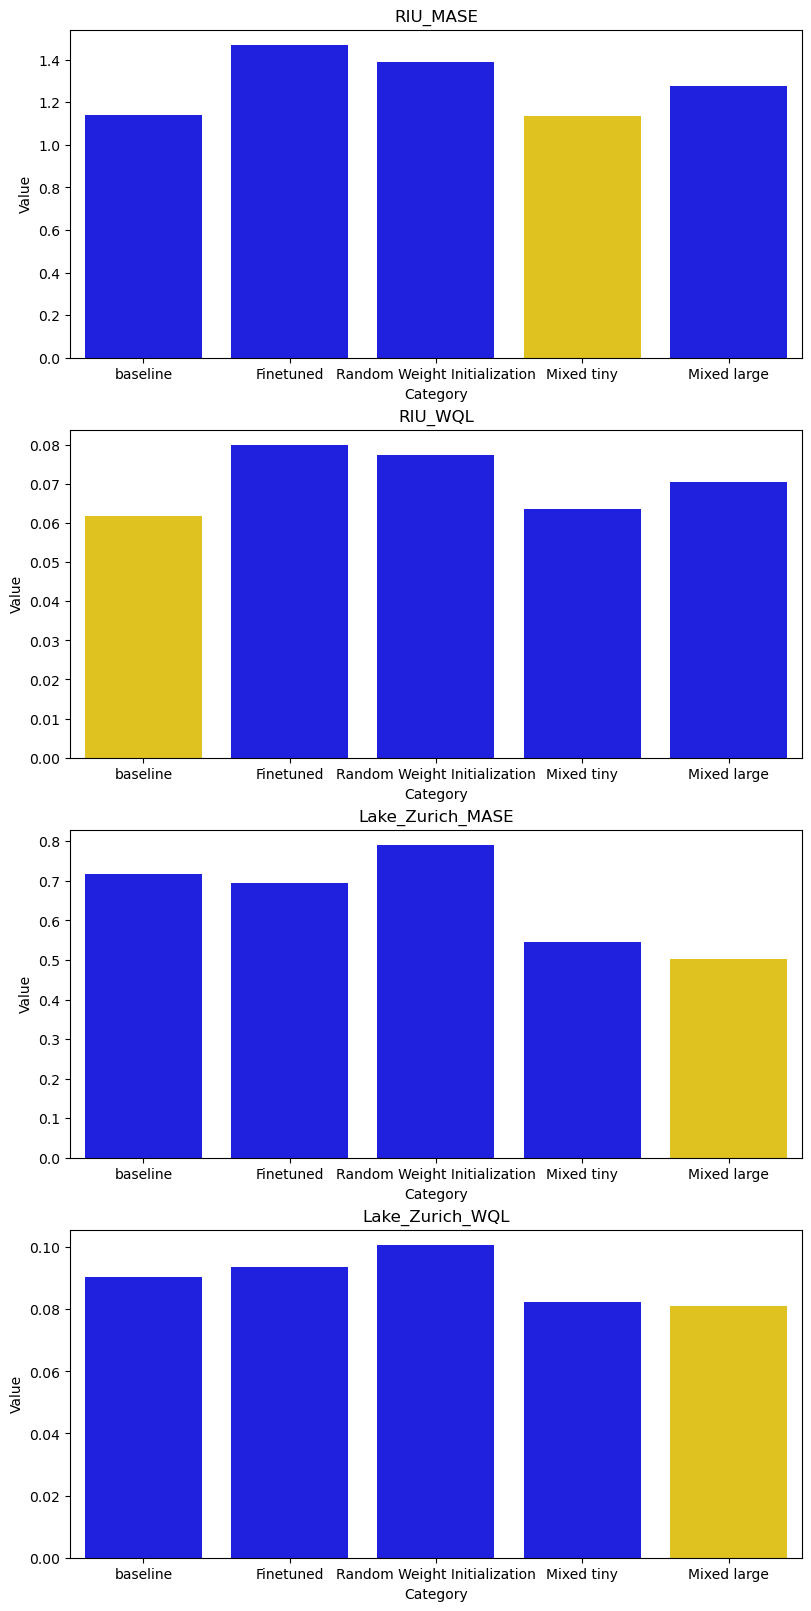

In [105]:
plot_bar_charts(ec1)

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_38103/168844672.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x="index", y="Value", ax=ax, palette=colors)
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_38103/168844672.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x="index", y="Value", ax=ax, palette=colors)


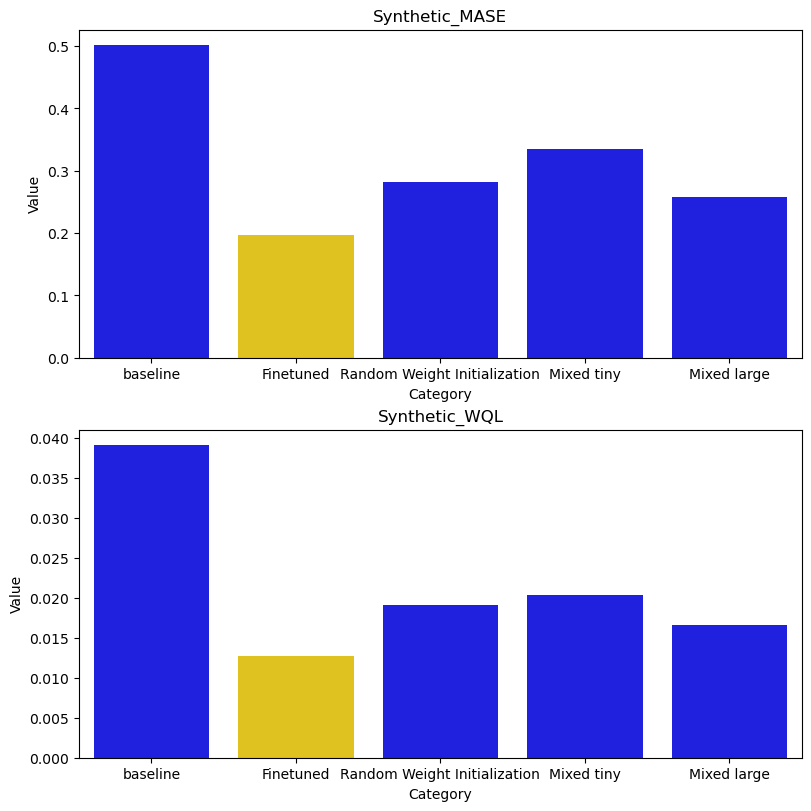

In [106]:
plot_bar_charts(syn1)

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_38103/168844672.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x="index", y="Value", ax=ax, palette=colors)
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_38103/168844672.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x="index", y="Value", ax=ax, palette=colors)
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_38103/168844672.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x="index", y="Value

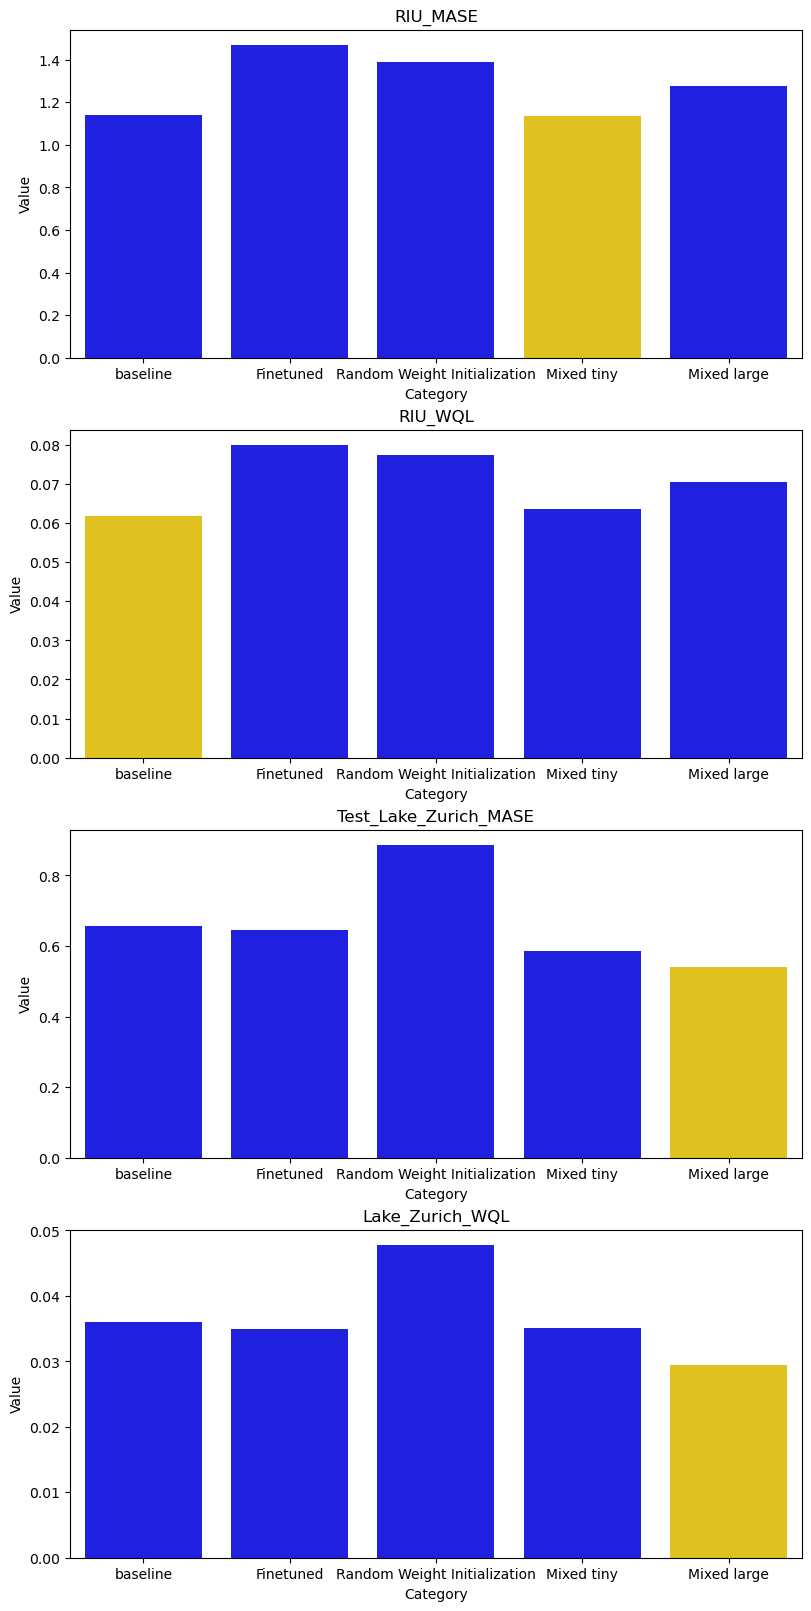

In [107]:
plot_bar_charts(ec2)